**ECG Heartbeat Categorization Dataset**

I tried to use custom CNN with Conv1D and SeparableConv1D layers on ECG Dataset.

In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error

from mlxtend.plotting import plot_confusion_matrix

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, Flatten, SeparableConv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model

from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

np.random.seed(4)

import pickle
from sklearn.preprocessing import OneHotEncoder

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_normal.csv', 'ptbdb_abnormal.csv']


In [125]:
df = pd.read_csv("../input/mitbih_train.csv", header=None)
df2 = pd.read_csv("../input/mitbih_test.csv", header=None)
df3= pd.read_csv("../input/ptbdb_abnormal.csv", header=None)
df = pd.concat([df, df2,df3], axis=0)

In [126]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119952 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 173.0 MB


Lets look at the number of data for each labels

In [128]:
df[187].value_counts()

0.0    90589
1.0    13285
4.0     8039
2.0     7236
3.0      803
Name: 187, dtype: int64

In [129]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [130]:
del df
del df2
del M

# Visual Input

In [131]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

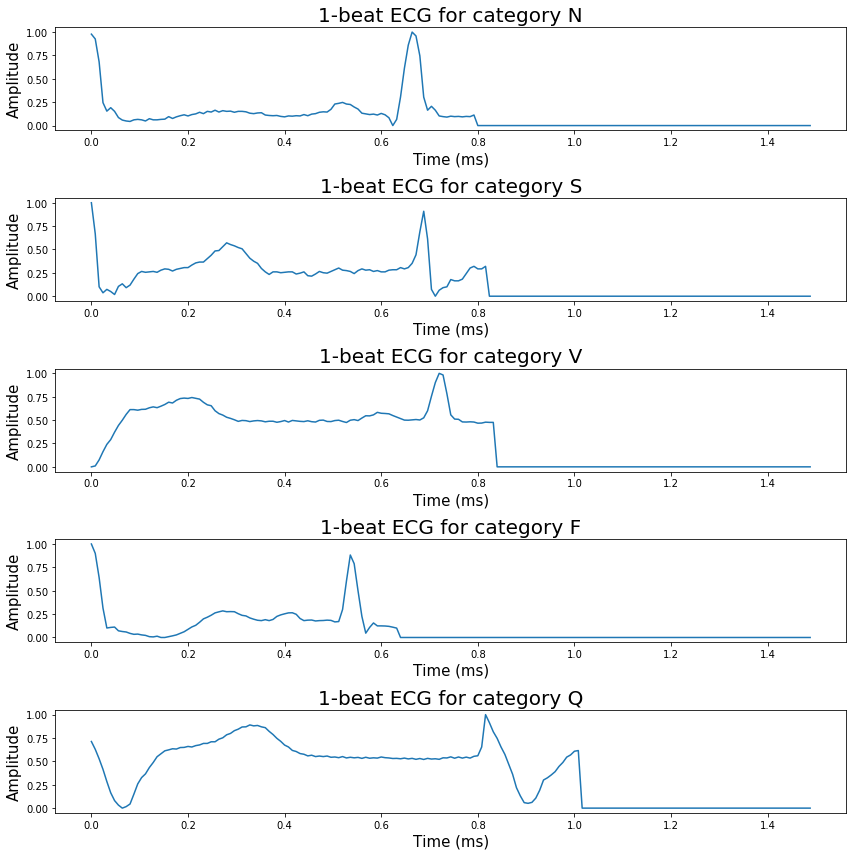

In [132]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(12,12))
plt.subplot(5, 1, 1)

plt.plot(x, X[C0, :][0], label="Cat. N")
plt.title("1-beat ECG for category N", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)

plt.subplot(5,1, 2)
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.title("1-beat ECG for category S", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)

plt.subplot(5,1,3)
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.title("1-beat ECG for category V", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)

plt.subplot(5,1, 4)
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.title("1-beat ECG for category F", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)

plt.subplot(5,1,5)
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.title("1-beat ECG for category Q", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.tight_layout()
plt.show()

# Data augmentation

Data Augmentation on the smallest class 3 to the same level as class 1. With that we will be able to have a test set of around 5x800 observations.

In [133]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

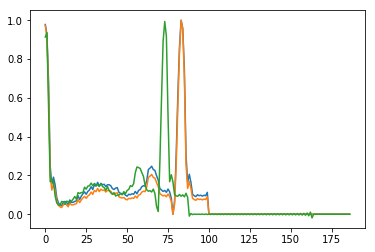

In [134]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [135]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

# Split

In [136]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [137]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [138]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [139]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (119572, 187, 1)
y_train (119572,)
X_test (4000, 187, 1)
y_test (4000,)


In [140]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [141]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (119572, 187, 1)
y_train (119572, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


**Custom 1D CNN Model**

In [142]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [145]:
def build_model():
    input_img = Input(shape=(feature, depth), name='ImageInput')
    x = Conv1D(32, 3, activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv1D(32, 3, activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling1D(2, name='pool1')(x)
    
    x = SeparableConv1D(32, 3, activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv1D(32, 3, activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling1D(2, name='pool2')(x)
    
    x = SeparableConv1D(64, 3, activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv1D(64, 3, activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    
    x = SeparableConv1D(64, 3, activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling1D(2, name='pool3')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(128, activation='relu', name='fc1')(x)
    x = Dropout(0.6, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model



In [146]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 187, 1)            0         
_________________________________________________________________
Conv1_1 (Conv1D)             (None, 187, 32)           128       
_________________________________________________________________
Conv1_2 (Conv1D)             (None, 187, 32)           3104      
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 93, 32)            0         
_________________________________________________________________
Conv2_1 (SeparableConv1D)    (None, 93, 32)            1152      
_________________________________________________________________
Conv2_2 (SeparableConv1D)    (None, 93, 32)            1152      
_________________________________________________________________
pool2 (MaxPooling1D)         (None, 46, 32)            0         
__________

In [147]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [148]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [149]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [150]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

Train on 119572 samples, validate on 4000 samples
Epoch 1/75
 - 11s - loss: 0.6837 - acc: 0.7921 - val_loss: 3.4886 - val_acc: 0.3113
Epoch 2/75
 - 6s - loss: 0.3458 - acc: 0.8788 - val_loss: 2.0829 - val_acc: 0.3645
Epoch 3/75
 - 6s - loss: 0.2368 - acc: 0.9246 - val_loss: 3.5669 - val_acc: 0.4750
Epoch 4/75
 - 6s - loss: 0.1858 - acc: 0.9433 - val_loss: 1.3020 - val_acc: 0.6680
Epoch 5/75
 - 6s - loss: 0.1547 - acc: 0.9534 - val_loss: 0.5365 - val_acc: 0.8148
Epoch 6/75
 - 6s - loss: 0.1390 - acc: 0.9586 - val_loss: 0.5754 - val_acc: 0.7990
Epoch 7/75
 - 6s - loss: 0.1239 - acc: 0.9634 - val_loss: 0.5111 - val_acc: 0.8502
Epoch 8/75
 - 6s - loss: 0.1190 - acc: 0.9649 - val_loss: 0.3263 - val_acc: 0.8990
Epoch 9/75
 - 6s - loss: 0.1083 - acc: 0.9678 - val_loss: 0.2548 - val_acc: 0.9095
Epoch 10/75
 - 6s - loss: 0.1010 - acc: 0.9699 - val_loss: 1.3375 - val_acc: 0.6842
Epoch 11/75
 - 6s - loss: 0.0955 - acc: 0.9714 - val_loss: 0.3891 - val_acc: 0.8907
Epoch 12/75
 - 6s - loss: 0.0892 -

In [151]:
# Get predictions
preds = model.predict(X_test, batch_size=1000)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(4000, 1)
(4000,)


Lets look at the confusion matrix 

<Figure size 432x288 with 0 Axes>

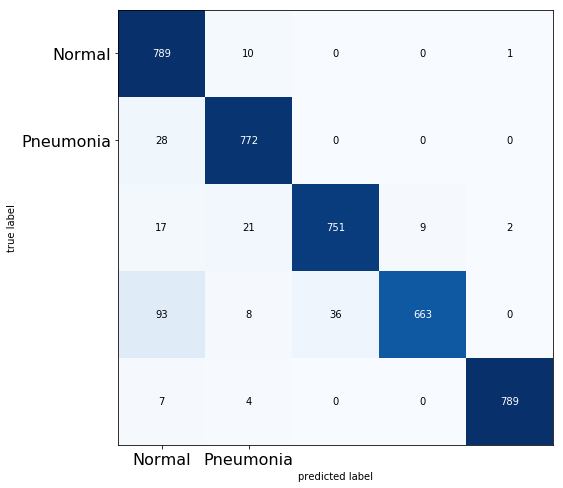

In [152]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Lets plot the Training and test accuracy & Loss graph!!

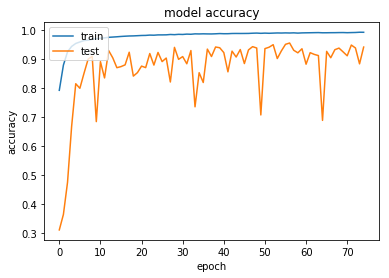

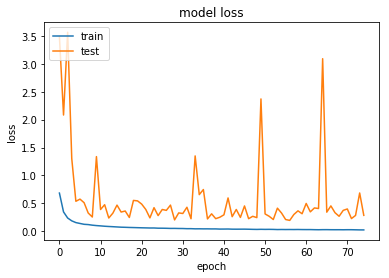

In [153]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()